# 03_model_training_electra.ipynb
- Fine-tuning du modèle ELECTRA-Small pour la classification de sentiments sur Twitter
# 1 - Imports & configuration

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, TextClassificationPipeline

import os
project_root = os.path.abspath("..")
os.chdir(project_root)

import sys
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.model_training import train_electra_pipeline
from src.utils.tracking_utils import log_gpu_info
from src.utils.evaluation_utils import evaluate_model_predictions
from src.utils.device_utils import check_gpu
from src.utils.visualization_utils import plot_confusion_matrix
from src.utils.inference_utils import predict_with_electra
from src.evaluate import evaluate_classification_metrics

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0516 09:32:33.944000 8308 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
print("Répertoire actif :", os.getcwd())

Répertoire actif : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2


In [3]:
device = check_gpu()

🔍 Vérification GPU (torch, tensorflow, nvidia-smi)...
✅ torch.cuda : NVIDIA GeForce GTX 1060 6GB (CUDA 11.8)
✅ TensorFlow : /physical_device:GPU:0 (CUDA 64_112, cuDNN 64_8)
✅ nvidia-smi : disponible
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |


# 2 - Chargement des données nettoyées

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
file_path = "data/processed/tweets_cleaned.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Fichier introuvable : {file_path}")

In [6]:
df = pd.read_csv(file_path)

df = df.dropna(subset = ["text", "label"]).copy()
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

In [7]:
X = df["text"].tolist()
y = df["label"].tolist()

In [8]:
y = [int(label) for label in y]
assert set(y).issubset({0, 1}), f"⚠️ Labels invalides détectés : {set(y)}"

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99735 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        99735 non-null  int32 
 1   text         99735 non-null  object
 2   text_length  99735 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 2.7+ MB


# 3 - Découpage train / test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 70)

# 4 - Entraînement du modèle ELECTRA

In [11]:
model_dir = "models/electra_model"

In [12]:
model, tokenizer = train_electra_pipeline(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    model_dir = model_dir,
    force_retrain = False
)

🧪 Fichiers attendus dans models/electra_model :
   ✅ config.json
   ✅ pytorch_model.bin
   ✅ tokenizer_config.json
   ✅ special_tokens_map.json
   ✅ tokenizer.json

🧠 model_files_ok = True / force_retrain = False

✅ Chargement du modèle Electra depuis les artefacts sauvegardés.


In [13]:
# model = ElectraForSequenceClassification.from_pretrained("models/electra_model")
# tokenizer = ElectraTokenizerFast.from_pretrained("models/electra_model")
# best_checkpoint = "tmp_electra/checkpoint-14961"

# model = ElectraForSequenceClassification.from_pretrained(best_checkpoint)
# tokenizer = ElectraTokenizerFast.from_pretrained(best_checkpoint)

In [14]:
model_dir = "models/electra_model"

model = ElectraForSequenceClassification.from_pretrained(model_dir)
tokenizer = ElectraTokenizerFast.from_pretrained(model_dir)

print("✅ Modèle et tokenizer Electra chargés depuis models/electra_model")

✅ Modèle et tokenizer Electra chargés depuis models/electra_model


In [15]:
# # Sauvegarde manuelle dans le dossier définitif
# model_dir = "models/electra_model"
# os.makedirs(model_dir, exist_ok=True)
# model.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

In [16]:
print("pytorch_model.bin exists:",
      os.path.exists("models/electra_model/pytorch_model.bin"))

pytorch_model.bin exists: True


In [17]:
from transformers import PreTrainedModel
isinstance(model, PreTrainedModel)

True

In [18]:
# Sauvegarde manuelle des artefacts si le fichier .bin n’a pas été généré
# model.save_pretrained("models/electra_model")
# tokenizer.save_pretrained("models/electra_model")

# model.save_pretrained("models/electra_model")
# tokenizer.save_pretrained("models/electra_model")

# 5 - Prédictions sur l’ensemble du test set (précis + GPU-aware)

In [19]:
# pipe = TextClassificationPipeline(model = model, tokenizer = tokenizer, return_all_scores = False, device = 0 if torch.cuda.is_available() else -1)
# y_pred = predict_with_electra(
#     model = model,
#     tokenizer = tokenizer,
#     texts = X_test,
#     device = device,
#     return_dataframe = False
# )
y_pred = predict_with_electra(
    model = model,
    tokenizer = tokenizer,
    texts = X_test,
    device = 0 if torch.cuda.is_available() else -1,
    return_dataframe = False
)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


# 6 - Évaluation centralisée (scores + matrice)

📊 ELECTRA - Accuracy : 0.8216 | F1-score : 0.8188


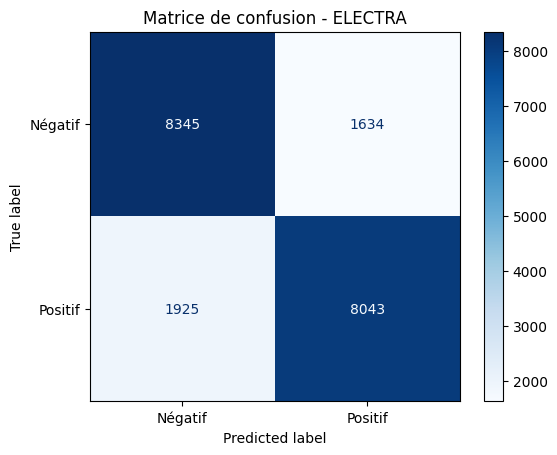

In [20]:
scores = evaluate_classification_metrics(
    y_true = y_test,
    y_pred = y_pred,
    model_name = "ELECTRA",
    save_path = "results/model_scores_logreg_vs_electra.csv"
)

## 6.1 - Rapport détaillé (précision, rappel, F1 par classe)

In [21]:
evaluate_model_predictions(
    y_true = y_test,
    y_pred = y_pred,
    save_path = "results/electra_classification_report.txt"
)

              precision    recall  f1-score   support

     Négatif       0.81      0.84      0.82      9979
     Positif       0.83      0.81      0.82      9968

    accuracy                           0.82     19947
   macro avg       0.82      0.82      0.82     19947
weighted avg       0.82      0.82      0.82     19947



'              precision    recall  f1-score   support\n\n     Négatif       0.81      0.84      0.82      9979\n     Positif       0.83      0.81      0.82      9968\n\n    accuracy                           0.82     19947\n   macro avg       0.82      0.82      0.82     19947\nweighted avg       0.82      0.82      0.82     19947\n'

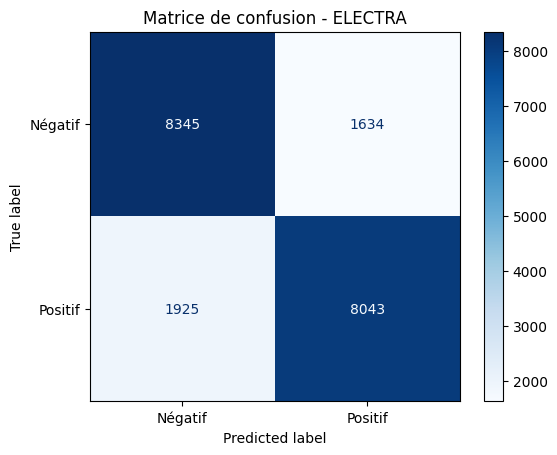

In [22]:
plot_confusion_matrix(
    y_true = y_test,
    y_pred = y_pred,
    labels = ["Négatif", "Positif"],
    title = "Matrice de confusion - ELECTRA"
)

# 7 - Prédictions sur 2000 tweets

In [23]:
sample_preds = pd.DataFrame({
    "text": X_test[:2000],
    "label": y_test[:2000]
})

In [24]:
sample_preds["prediction"] = predict_with_electra(
    model = model,
    tokenizer = tokenizer,
    texts = sample_preds["text"],
    device = device,
    return_dataframe = False
)

In [25]:
sample_preds.to_csv("results/electra_predictions_sample.csv", index = False)

# 8 - Affichage graphique comparatif des modèles

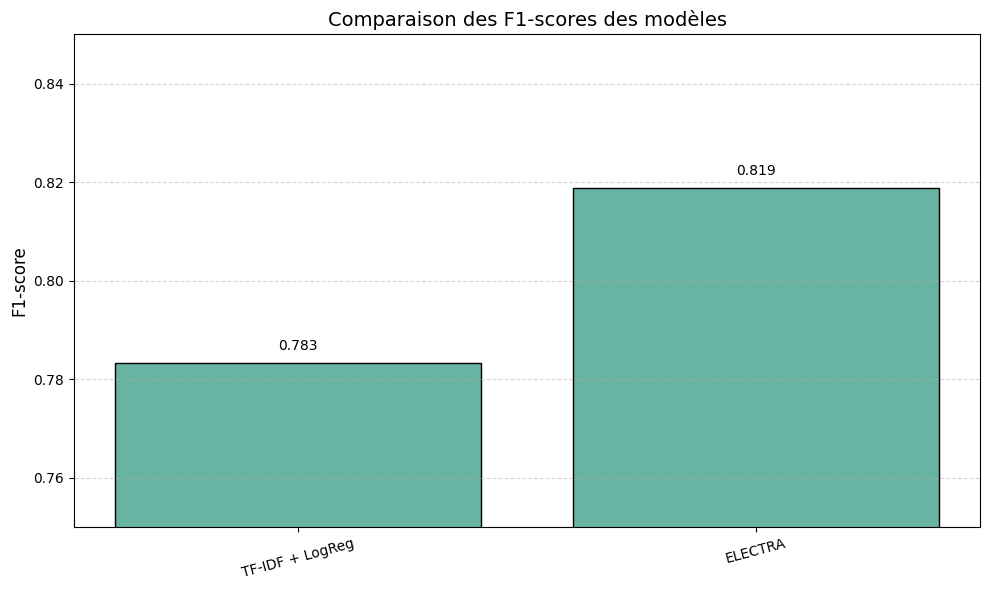

In [26]:
# Chargement des scores
results_path = "results/model_scores_logreg_vs_electra.csv"

if os.path.exists(results_path):
    df_scores = pd.read_csv(results_path)

    # Création du graphique
    plt.figure(figsize = (10, 6))
    bars = plt.bar(df_scores["Modèle"], df_scores["F1-score"], edgecolor = "black", color = "#69b3a2")

    # Ajout des scores sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.002, f"{height:.3f}",
                 ha = 'center', va = 'bottom', fontsize = 10)

    plt.title("Comparaison des F1-scores des modèles", fontsize = 14)
    plt.ylabel("F1-score", fontsize = 12)
    plt.ylim(0.75, 0.85)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.5)
    plt.xticks(rotation = 15)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Le fichier de résultats est introuvable :", results_path)
